In [12]:
import numpy as np
import pandas as pd

# Load and preprocess the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Define column names: first two columns are ID and Diagnosis, followed by 30 feature columns
columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]

# Load the dataset into a pandas DataFrame
data = pd.read_csv(url, header=None, names=columns)

# Convert 'Diagnosis' column into binary values: Malignant (M) = 1, Benign (B) = 0
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Separate features (X) and labels (y) for machine learning
X = data.drop(["ID", "Diagnosis"], axis=1).values  # Dropping ID and Diagnosis, keeping only features
y = data['Diagnosis'].values.reshape(-1, 1)       # Converting labels into a 2D array

# Function to split the dataset into training and test sets manually
def manual_train_test_split(X, y, test_size=0.2, random_seed=42):
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Combine features and labels to shuffle them together
    data = np.hstack((X, y))
    np.random.shuffle(data)  # Shuffle the combined data
    
    # Calculate the split index based on test_size
    split_index = int((1 - test_size) * len(y))
    
    # Split the shuffled data back into training and test sets
    X_train, X_test = data[:split_index, :-1], data[split_index:, :-1]
    y_train, y_test = data[:split_index, -1:], data[split_index:, -1:]
    
    # Return the training and test sets
    return X_train, X_test, y_train, y_test

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = manual_train_test_split(X, y)

# Function to standardize features (zero mean, unit variance)
def manual_standard_scaler(X):
    # Calculate mean and standard deviation of each feature
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # Scale features using standardization formula
    X_scaled = (X - mean) / std
    
    # Return scaled data along with the mean and standard deviation for reference
    return X_scaled, mean, std

# Standardize the training data
X_train, train_mean, train_std = manual_standard_scaler(X_train)

# Standardize the test data using the same mean and std from the training set
X_test = (X_test - train_mean) / train_std

# Define a class for the neural network
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases with small random values
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        # Sigmoid activation function to introduce non-linearity
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Derivative of sigmoid used for backpropagation
        return x * (1 - x)

    def forward_propagation(self, X):
        # Calculate input and output for the hidden layer
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.sigmoid(self.hidden_input)
        
        # Calculate input and output for the output layer
        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output = self.sigmoid(self.output_input)
        return self.output

    def compute_loss(self, y, output):
        # Calculate Mean Squared Error (MSE) loss for evaluation
        return np.mean((y - output) ** 2)

    def backward_propagation(self, X, y):
        # Calculate error at the output layer
        error = y - self.output
        d_output = error * self.sigmoid_derivative(self.output)  # Derivative of the output layer
        
        # Calculate error and gradient for the hidden layer
        error_hidden = d_output.dot(self.weights_hidden_output.T)
        d_hidden = error_hidden * self.sigmoid_derivative(self.hidden_output)

        # Update weights and biases using gradient descent
        self.weights_hidden_output += self.hidden_output.T.dot(d_output) * 0.1
        self.bias_output += np.sum(d_output, axis=0, keepdims=True) * 0.1
        self.weights_input_hidden += X.T.dot(d_hidden) * 0.1
        self.bias_hidden += np.sum(d_hidden, axis=0, keepdims=True) * 0.1

    def train(self, X, y, epochs=1000):
        self.loss_values = []  # Initialize an empty list to store loss values
        # Train the neural network over multiple epochs
        for epoch in range(epochs):
            # Perform forward propagation to calculate predictions
            output = self.forward_propagation(X)
            # Compute and store the loss
            loss = self.compute_loss(y, output)
            self.loss_values.append(loss)
        
            
            # Print the loss every 100 epochs
            if (epoch + 1) % 100 == 0:
                loss = self.compute_loss(y, output)
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")
            
            # Perform backward propagation to update weights and biases
            self.backward_propagation(X, y)

    def predict(self, X):
        # Predict class labels based on the output probabilities
        output = self.forward_propagation(X)
        return (output > 0.5).astype(int)

# Initialize the neural network with appropriate layer sizes
nn = NeuralNetwork(input_size=30, hidden_size=10, output_size=1)

# Train the neural network using the training data
nn.train(X_train, y_train, epochs=1000)

# Evaluate the trained neural network on the test set
y_pred = nn.predict(X_test)

# Calculate accuracy by comparing predictions to actual labels
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Epoch 100, Loss: 0.0080
Epoch 200, Loss: 0.0060
Epoch 300, Loss: 0.0053
Epoch 400, Loss: 0.0050
Epoch 500, Loss: 0.0048
Epoch 600, Loss: 0.0047
Epoch 700, Loss: 0.0046
Epoch 800, Loss: 0.0046
Epoch 900, Loss: 0.0046
Epoch 1000, Loss: 0.0045
Accuracy: 0.9649


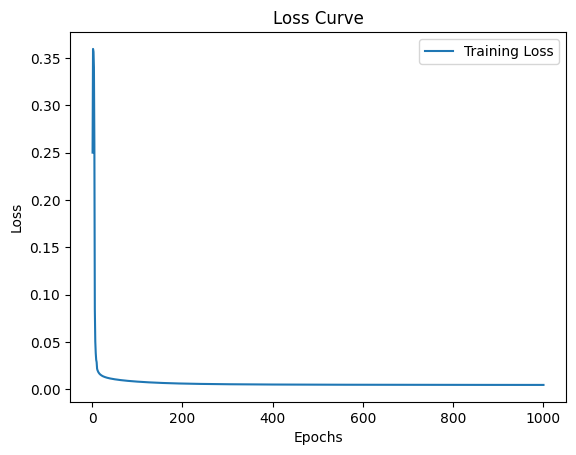

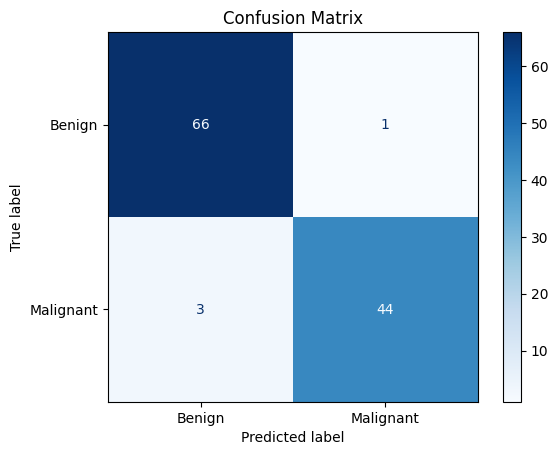

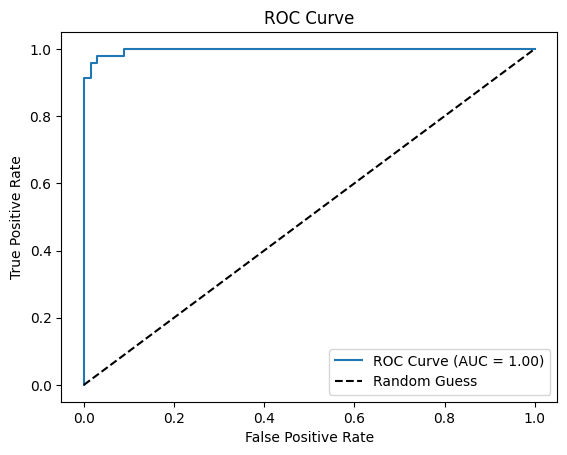

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


loss_values = nn.loss_values
epochs = range(1, len(loss_values) + 1)
# Plotting the loss curve
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
y_prob = nn.forward_propagation(X_test)  # Predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()